# EDA: Home Insurance Model

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('..')

In [3]:
from src.preprocessing import (
    batch_parse_salary,
    _combine_name_cols,
    combine_time_with_employer,
    import_mortgage_table,
    import_campaign_table
)

In [4]:
# Import campaign dataset
campaign_df = pd.read_csv('../data/Campaign.csv')
campaign_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No


In [5]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32060 entries, 0 to 32059
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   participant_id        32060 non-null  float64
 1   name_title            19859 non-null  object 
 2   first_name            32060 non-null  object 
 3   last_name             32060 non-null  object 
 4   age                   32060 non-null  int64  
 5   postcode              32060 non-null  object 
 6   marital_status        32060 non-null  object 
 7   education             32060 non-null  object 
 8   job_title             32060 non-null  object 
 9   occupation_level      32060 non-null  int64  
 10  education_num         32060 non-null  int64  
 11  familiarity_FB        32060 non-null  int64  
 12  view_FB               32060 non-null  int64  
 13  interested_insurance  32060 non-null  int64  
 14  company_email         32060 non-null  object 
 15  created_account    

In [6]:
campaign_df.created_account.value_counts()

No     2787
Yes     240
Name: created_account, dtype: int64

Notice how we only have about 10% of `created_account` filled. There are a few options we may wish to consider:

1. Drop all unlabelled data and never use it.
2. Use a semi-supervised model. 
3. Keep unlabelled data as a "holdout" set that can be used to tune the decision threshold for the rest of the model.

We can also drop quite a few of these columns for different reasons - see `assumptions.md` for the explanations (and the presentation).

In [7]:
# Import mortgage dataset
mortgage_df = pd.read_csv('../data/Mortgage.csv')
mortgage_df.head()

,full_name,dob,town,paye,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,new_mortgage,sex,religion,relationship,race,native_country,workclass,demographic_characteristic
0,Mr. Dale Coles,1979-05-10,Edinburgh,53791313,£18109 yearly,20,6,40,2174,0,Yes,Male,Christianity,Not-in-family,White,United Kingdom,State-gov,77516
1,Joel Allen,1968-07-06,Leeds,24005258,£16945 yearly,28,1,13,0,0,Yes,Male,Christianity,Husband,White,United Kingdom,Self-emp-not-inc,83311
2,Mr. Craig Marc Davis,1979-02-10,Edinburgh,44124649,£729.87 pw,14,5,40,0,0,Yes,Male,Christianity,Not-in-family,White,United Kingdom,Private,215646
3,Mr. Brandon Thornton,1965-10-20,Edinburgh,85701281,£19087 yearly,32,6,40,0,0,Yes,Male,Christianity,Husband,Black,United Kingdom,Private,234721
4,Miss Brett Carol Fletcher,1990-02-20,Swindon,BR442000,£2741.5 per month,3,6,40,0,0,Yes,Female,Christianity,Wife,Black,Sweden,Private,338409


In [8]:
mortgage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   full_name                   32561 non-null  object
 1   dob                         32561 non-null  object
 2   town                        32561 non-null  object
 3   paye                        32561 non-null  object
 4   salary_band                 32561 non-null  object
 5   years_with_employer         32561 non-null  int64 
 6   months_with_employer        32561 non-null  int64 
 7   hours_per_week              32561 non-null  int64 
 8   capital_gain                32561 non-null  int64 
 9   capital_loss                32561 non-null  int64 
 10  new_mortgage                32561 non-null  object
 11  sex                         32561 non-null  object
 12  religion                    32561 non-null  object
 13  relationship                32561 non-null  ob

Again, we can also drop quite a few of these columns for different reasons - see `assumptions.md` for the explanations (and the presentation).

---

The tables are in the correct order with names, it's just that the Mortgage table is longer. Will just stitch together here rather than build functionality to match names. Not optimal for a production system.

Also, just importing these tables with standard Pandas parameters doesn't result in the most optimised DataFrames so we can do some work there to improve the datatypes etc.

Now I will use the import functions from the code base to import only the relevant columns in the proper dtypes.

In [9]:
campaign_df = import_campaign_table('../data/Campaign.csv')

In [10]:
campaign_df.head()

,age,marital_status,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account
0,39,Never-married,1,17,7,9,0,No
1,50,Married-civ-spouse,4,17,9,6,1,No
2,38,Divorced,12,12,5,4,1,No
3,53,Married-civ-spouse,1,9,9,2,0,No
4,28,Married-civ-spouse,12,17,8,9,1,No


In [11]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32060 entries, 0 to 32059
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   32060 non-null  int64   
 1   marital_status        32060 non-null  category
 2   occupation_level      32060 non-null  int64   
 3   education_num         32060 non-null  int64   
 4   familiarity_FB        32060 non-null  int64   
 5   view_FB               32060 non-null  int64   
 6   interested_insurance  32060 non-null  int64   
 7   created_account       3027 non-null   string  
dtypes: category(1), int64(6), string(1)
memory usage: 1.7 MB


In [12]:
mortgage_df = import_mortgage_table("../data/Mortgage.csv")

Getting exhange rates...


In [13]:
mortgage_df.head()

,salary_band,hours_per_week,workclass,total_months_with_employer,pays_captial_tax
0,18109.00,40,State-gov,246,1
1,16945.00,13,Self-emp-not-inc,337,0
2,37953.24,40,Private,173,0
3,19087.00,40,Private,390,0
4,32898.00,40,Private,42,0


In [14]:
mortgage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   salary_band                 32255 non-null  float64 
 1   hours_per_week              32561 non-null  int64   
 2   workclass                   30725 non-null  category
 3   total_months_with_employer  32561 non-null  int64   
 4   pays_captial_tax            32561 non-null  int64   
dtypes: category(1), float64(1), int64(3)
memory usage: 1.0 MB


In [15]:
combined_df = pd.concat([campaign_df, mortgage_df], axis=1)

In [16]:
columns = [
    'age',
    'marital_status',
    'occupation_level',
    'education_num',
    'familiarity_FB',
    'view_FB',
    'interested_insurance',
    'salary_band',
    'hours_per_week',
    'workclass',
    'total_months_with_employer',
    'pays_captial_tax',
    'created_account'
]
combined_df = combined_df[columns]

In [17]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         32060 non-null  float64 
 1   marital_status              32060 non-null  category
 2   occupation_level            32060 non-null  float64 
 3   education_num               32060 non-null  float64 
 4   familiarity_FB              32060 non-null  float64 
 5   view_FB                     32060 non-null  float64 
 6   interested_insurance        32060 non-null  float64 
 7   salary_band                 32255 non-null  float64 
 8   hours_per_week              32561 non-null  int64   
 9   workclass                   30725 non-null  category
 10  total_months_with_employer  32561 non-null  int64   
 11  pays_captial_tax            32561 non-null  int64   
 12  created_account             3027 non-null   string  
dtypes: category(2), 

In [18]:
combined_df.head()

,age,marital_status,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,salary_band,hours_per_week,workclass,total_months_with_employer,pays_captial_tax,created_account
0,39.0,Never-married,1.0,17.0,7.0,9.0,0.0,18109.00,40,State-gov,246,1,No
1,50.0,Married-civ-spouse,4.0,17.0,9.0,6.0,1.0,16945.00,13,Self-emp-not-inc,337,0,No
2,38.0,Divorced,12.0,12.0,5.0,4.0,1.0,37953.24,40,Private,173,0,No
3,53.0,Married-civ-spouse,1.0,9.0,9.0,2.0,0.0,19087.00,40,Private,390,0,No
4,28.0,Married-civ-spouse,12.0,17.0,8.0,9.0,1.0,32898.00,40,Private,42,0,No


## Why is Capital Gain (+Loss) so predictive?

The `capital_gain` and `capitak_loss` chars are so much more predictive than the others that it borderlines on suspicious. I'm going to explore those chars in a bit more detail across the whole population and then do a univariate analysis against the outcome flag. 

In [19]:
combined_df['pays_captial_tax'].describe()

count    32561.000000
mean         0.129941
std          0.336243
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pays_captial_tax, dtype: float64

In [20]:
# Display percentages that are zero
n_cap_gain = (combined_df["pays_captial_tax"] == 1).sum()
n_rows = combined_df.shape[0]
print(f"Percentage capital_gain = 0: {(n_cap_gain/n_rows)*100:0.1f}%")

Percentage capital_gain = 0: 13.0%


It would be tempting to remove this column right away for a few reasons:

1. It is a zero-inflated column - the vast majority of customers do not pay capital.
2. It will probably behave more like a binary column (does/doesn't pay tax on capital gains)

Let's dig a little more into it..

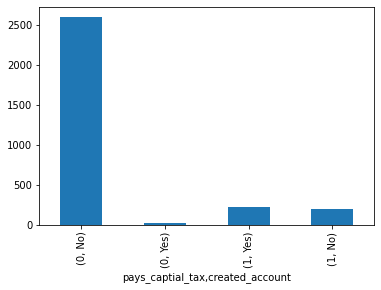

In [65]:
df = combined_df[['pays_captial_tax', 'created_account']].groupby('pays_captial_tax').value_counts().plot(kind="bar")

In [48]:
combined_df[combined_df.created_account != -1]['pays_captial_tax'].value_counts()

0    2615
1     412
Name: pays_captial_tax, dtype: int64

In [ ]:
combined_df

In [50]:
(21 / 2615) * 100

0.8030592734225621

In [52]:
(219 / 412) * 100

53.15533980582524

In [22]:
# Percentage of customers who pay capital tax and create a home insurance account
pays_capital_tax = combined_df[combined_df.pays_captial_tax == 1.0]
tax_value_counts = pays_capital_tax.created_account.value_counts()
percent = 100 * tax_value_counts["Yes"] / tax_value_counts.sum()
print(f"Percentage of capital-tax paying customers who took out home insurance: {percent:0.1f}%")

Percentage of capital-tax paying customers who took out home insurance: 53.2%


In [24]:
# Percentage of customers who don't pay capital tax and create a home insurance account
not_pay_capital_tax = combined_df[combined_df.pays_captial_tax == 0.0]
tax_value_counts = not_pay_capital_tax.created_account.value_counts()
percent = 100 * tax_value_counts["Yes"] / tax_value_counts.sum()
print(f"Percentage of non capital-tax paying customers who took out home insurance: {percent:0.1f}%")

Percentage of non capital-tax paying customers who took out home insurance: 0.8%


There you have it - you are 65x more likely to buy home insurance if you have paid capital gains tax. My guess for the reason would be this: 

> You only pay capital gains tax on properties that aren't your main home, so the chances are that this mortgage is for a second property that you intend to rent out. Many lenders require that you purchase home/lardlord insurance on rental properties as part of the terms of the mortgage, so these people may be far more likely to take out home insurance. 

This is a good discovery as it explains why the model weight so much more to customers who show non-zero values in these fields. Problem is we've built a model which mainly looks to discover one thing and doesn't give a fair representation of the model performance for the rest of the customers. I'm going to suggest a segmented model: the first for customers who pay capital gains and another for those that don't. 

In [38]:
combined_df.groupby('pays_captial_tax')['created_account'].mean()

TypeError: Cannot perform reduction 'mean' with string dtype

In [32]:
combined_df

,age,marital_status,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,salary_band,hours_per_week,workclass,total_months_with_employer,pays_captial_tax,created_account
0,39.0,Never-married,1.0,17.0,7.0,9.0,0.0,1.810900e+04,40,State-gov,246,1,No
1,50.0,Married-civ-spouse,4.0,17.0,9.0,6.0,1.0,1.694500e+04,13,Self-emp-not-inc,337,0,No
2,38.0,Divorced,12.0,12.0,5.0,4.0,1.0,3.795324e+04,40,Private,173,0,No
3,53.0,Married-civ-spouse,1.0,9.0,9.0,2.0,0.0,1.908700e+04,40,Private,390,0,No
4,28.0,Married-civ-spouse,12.0,17.0,8.0,9.0,1.0,3.289800e+04,40,Private,42,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.907300e+04,38,Private,9,0,<NA>
32557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.818178e+11,40,Private,206,0,<NA>
32558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.102688e+04,40,Private,255,0,<NA>
32559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.484800e+04,20,Private,33,0,<NA>
